<a href="https://colab.research.google.com/github/garylau1/model_training/blob/main/ResNet_from_scatach.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

Deep learning has revolutionized the field of computer vision, and one of its cornerstone architectures is the Residual Network (ResNet). ResNet-50, a specific variant of this architecture, is widely recognized for its exceptional ability to train deep networks by addressing the vanishing gradient problem. In this project, I aim to implement ResNet-50 from scratch to gain a deeper understanding of its inner workings, layer-by-layer construction, and the overall design principles that make it so effective.

The implementation process begins with building the foundational components of ResNet-50, including the Bottleneck blocks, which are the core building blocks of the network. These blocks allow ResNet-50 to achieve remarkable depth while maintaining computational efficiency. Subsequently, I will assemble the other essential layers, such as the convolutional layers, downsampling modules, and fully connected layers, to complete the architecture.

Once the architecture is fully constructed, I will demonstrate how to integrate pretrained weights into the custom model. By using pretrained weights, the model can leverage prior knowledge gained from training on large datasets, significantly enhancing its performance and reducing the training time required for new tasks. This final step not only validates the accuracy of the implementation but also showcases the versatility of ResNet-50 when applied to practical problems.

Through this project, I aim to develop a thorough understanding of ResNet-50 and its components, while also exploring the practical aspects of transferring knowledge using pretrained weights.

As part of further experiments, I will evaluate the impact of torch.compile on the training speed. This is essential because torch.compile can optimize the model execution by improving computational efficiency, and we aim to see how much it affects the performance on the GPU. The experiment will be conducted using the CIFAR-10 dataset, and the main goal is to observe the difference in training speed, rather than accuracy. This experiment will help determine the efficiency gains when using torch.compile and provide insight into its impact on real-time training on GPUs.



In [ ]:
import torch
#import the torch and nn module I need

device= "cuda" if torch.cuda.is_available() else "cpu"
from torch import nn

import torchvision

# Set the device globally
#torch.set_default_device(device)

torch.backends.cuda.matmul.allow_tf32 = True

#The Bottleneck block

The Bottleneck block is a critical component of the ResNet-50 architecture, designed to enhance computational efficiency while maintaining expressive power. This block uses a three-layer structure with 1x1, 3x3, and 1x1 convolutional layers to reduce and restore the feature map dimensions. This approach minimizes the computational cost while retaining the ability to extract complex features.

In this implementation, the Bottleneck block supports downsampling and flexible stride configurations, making it adaptable for different stages of the ResNet architecture. Additionally, the shortcut connection allows the network to learn residual mappings, addressing the degradation problem in deep networks.

This implementation includes options for downsampling, changing the kernel size, and stride adjustments, enabling seamless integration into deeper ResNet layers.

In [ ]:
class Bottleneck(nn.Module):
    """
    Implementation of the Bottleneck block for ResNet.

    The Bottleneck block is a three-layer residual block used in ResNet architectures.
    It performs dimensionality reduction and restoration using `1x1` convolutions
    while applying spatial processing with a `3x3` convolution. A shortcut
    connection is added to facilitate residual learning.

    Args:
        in_channel (int): Number of input channels.
        hidden_ (int): Number of intermediate channels (reduced dimension).
        out_channel (int): Number of output channels.
        kernel_sizes (int): Kernel size for `1x1` convolutions (default: 1).
        stride (int): Stride for convolutional layers (default: 1).
        downsample (bool): Whether to apply downsampling in the shortcut connection (default: True).
        change_kernel (bool): Whether to modify the stride in the `3x3` convolution (default: False).

    Attributes:
        conv1 (nn.Conv2d): First `1x1` convolution layer for dimensionality reduction.
        bn1 (nn.BatchNorm2d): BatchNorm layer for the first convolution.
        conv2 (nn.Conv2d): Second `3x3` convolution layer for spatial processing.
        bn2 (nn.BatchNorm2d): BatchNorm layer for the second convolution.
        conv3 (nn.Conv2d): Third `1x1` convolution layer for dimensionality restoration.
        bn3 (nn.BatchNorm2d): BatchNorm layer for the third convolution.
        relu (nn.ReLU): ReLU activation function.
        downsample (nn.Sequential): Optional downsampling shortcut connection.

    Methods:
        forward(x):
            Defines the forward pass of the Bottleneck block.
    """
    def __init__(self,
                 in_channel=256, hidden_=64, out_channel=256,
                 kernel_sizes=1, stride=1,
                 downsample=True, change_kernel=False):
        super().__init__()

        self.downsamples = downsample  # Flag for applying downsampling

        # First 1x1 convolution: reduces the number of channels (dimensionality reduction)
        self.conv1 = nn.Conv2d(
            in_channels=in_channel, out_channels=hidden_,
            kernel_size=kernel_sizes, stride=stride, bias=False
        )
        self.bn1 = nn.BatchNorm2d(hidden_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # Second 3x3 convolution: applies spatial processing
        self.conv2 = nn.Conv2d(
            in_channels=hidden_, out_channels=hidden_,
            kernel_size=3, padding=1, stride=stride, bias=False
        )
        if change_kernel:  # Modify stride for downsampling in the second convolution
            self.conv2 = nn.Conv2d(
                in_channels=hidden_, out_channels=hidden_,
                kernel_size=3, padding=1, stride=2, bias=False
            )
        self.bn2 = nn.BatchNorm2d(hidden_, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # Third 1x1 convolution: restores the number of channels (dimensionality restoration)
        self.conv3 = nn.Conv2d(
            in_channels=hidden_, out_channels=out_channel,
            kernel_size=kernel_sizes, stride=stride, bias=False
        )
        self.bn3 = nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        # ReLU activation: introduces non-linearity
        self.relu = nn.ReLU(inplace=True)

        # Downsampling shortcut if specified
        if self.downsamples:
            self.downsample = nn.Sequential(
                nn.Conv2d(
                    in_channels=in_channel, out_channels=out_channel,
                    kernel_size=kernel_sizes, stride=stride, bias=False
                ),
                nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            )
            if change_kernel:  # Modify stride for downsampling in the shortcut path
                self.downsample = nn.Sequential(
                    nn.Conv2d(
                        in_channels=in_channel, out_channels=out_channel,
                        kernel_size=kernel_sizes, stride=2, bias=False
                    ),
                    nn.BatchNorm2d(out_channel, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                )

    def forward(self, x):
        """
        Forward pass through the Bottleneck block.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, in_channel, height, width).

        Returns:
            torch.Tensor: Output tensor after applying the Bottleneck operations.
        """
        skip_x = x  # Store the original input for the residual connection

        # Apply the three convolutional layers with BatchNorm
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.bn3(x)

        # Add the residual (shortcut) connection
        if self.downsamples:
            x = self.downsample(skip_x) + x

        x = self.relu(x)  # Apply ReLU activation to the final output
        return x

# ResNet-50 architecture from scratch

In this section, we implement the ResNet-50 architecture from scratch. ResNet-50 is a widely used deep convolutional neural network designed for image classification tasks. It is known for its ability to achieve high performance on complex datasets due to the use of residual connections that mitigate the vanishing gradient problem in deep networks.

Our implementation follows these key steps:

Initial Layers: The model begins with a convolutional layer, followed by batch normalization, ReLU activation, and max pooling, which reduce the input's spatial dimensions while capturing essential features.
Residual Layers: The core of the model consists of four main stages (layer1 to layer4). Each stage is built using Bottleneck blocks, which include shortcut connections that directly add the input to the output of a stack of convolutional layers. The number of filters increases progressively across layers, allowing the model to learn hierarchical feature representations.
Global Pooling and Classification: After the residual layers, the model applies adaptive average pooling to reduce the spatial dimensions to a fixed size. A fully connected layer maps the extracted features to class probabilities.
This design reflects the structure of the original ResNet-50 architecture. By implementing it step by step, we not only replicate its functionality but also gain a deeper understanding of its inner workings. Finally, we prepare the model to load pretrained weights, which enhances its performance on various tasks without the need for training from scratch.

In [ ]:
class ResNeT_copy(nn.Module):
    """
    Implementation of the ResNet-50 architecture from scratch.

    This class builds the ResNet-50 model step by step using the following components:
    - Initial convolutional layer with BatchNorm, ReLU, and max pooling.
    - Four sequential layers (layer1 to layer4) comprising Bottleneck blocks,
      with increasing channel dimensions as the network deepens.
    - Adaptive average pooling to reduce the spatial dimensions to 1x1.
    - Fully connected (linear) layer for classification.

    Args:
        None. Default settings are used to build ResNet-50.

    Attributes:
        conv1 (nn.Conv2d): Initial convolutional layer with 64 filters of size 7x7.
        bn1 (nn.BatchNorm2d): Batch normalization layer for the initial convolution.
        relu (nn.ReLU): ReLU activation function.
        maxpool (nn.MaxPool2d): Max pooling layer to reduce spatial dimensions.
        layer1-4 (nn.Sequential): Stacked Bottleneck blocks forming the ResNet layers.
        avgpool (nn.AdaptiveAvgPool2d): Adaptive average pooling to produce a fixed-size feature map.
        fc (nn.Linear): Fully connected layer for classification into 1000 classes.

    Methods:
        forward(x):
            Defines the forward pass through the entire ResNet-50 model.
    """
    def __init__(self):
        super().__init__()

        # Initial convolutional layer: captures basic image features
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=64,
            kernel_size=7, stride=2, padding=3, bias=False
        )
        self.bn1 = nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        self.relu = nn.ReLU(inplace=True)  # Adds non-linearity
        self.maxpool = nn.MaxPool2d(3, 2, 1, dilation=1, ceil_mode=False)

        # First layer: 64 input channels, expanded to 256 in the bottleneck blocks
        self.layer1 = nn.Sequential(
            Bottleneck(64),  # First Bottleneck block with downsampling
            *[Bottleneck(downsample=False) for i in range(2)]  # Two additional blocks
        )

        # Second layer: Expands from 256 to 512 channels
        self.layer2 = nn.Sequential(
            Bottleneck(256, 128, 512, change_kernel=True),  # First block with stride 2
            *[Bottleneck(512, 128, 512, downsample=False) for i in range(3)]  # Additional blocks
        )

        # Third layer: Expands from 512 to 1024 channels
        self.layer3 = nn.Sequential(
            Bottleneck(512, 256, 1024, change_kernel=True),  # First block with stride 2
            *[Bottleneck(1024, 256, 1024, downsample=False) for i in range(5)]  # Additional blocks
        )

        # Fourth layer: Expands from 1024 to 2048 channels
        self.layer4 = nn.Sequential(
            Bottleneck(1024, 512, 2048, change_kernel=True),  # First block with stride 2
            *[Bottleneck(2048, 512, 2048, downsample=False) for i in range(2)]  # Additional blocks
        )

        # Adaptive average pooling: Reduces each feature map to 1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))

        # Fully connected layer: Maps the 2048 features to 1000 classes
        self.fc = nn.Linear(2048, 1000, bias=True)

    def forward(self, x):
        """
        Forward pass through the ResNet-50 model.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, 3, height, width).

        Returns:
            torch.Tensor: Output tensor with shape (batch_size, 1000), representing class scores.
        """
        # Initial convolutional block
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Pass through the ResNet layers
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # Global average pooling
        x = self.avgpool(x)

        # Flatten and apply the fully connected layer
        x = torch.flatten(x, start_dim=1)
        x = self.fc(x)

        return x

# Verification:

To verify the functionality of the ResNet-50 implementation, we perform a simple forward pass using a test tensor. This tensor simulates an image batch with the following characteristics:

Shape: (1, 3, 224, 224):
Batch size = 1 (single image).
Channels = 3 (RGB image).
Height and Width = 224 pixels (standard input size for ResNet models).
The goal of this test is to ensure that the network processes the input tensor correctly through all layers and outputs a tensor with the expected shape (1, 1000)—representing predictions for 1000 classes (as per ImageNet classification).

In [ ]:
# Test the ResNet-50 implementation with a dummy input tensor.
test_tensor = torch.ones((1, 3, 224, 224))  # Create a tensor simulating a batch of RGB images.

# Instantiate the ResNet-50 model and pass the test tensor through it.
output = ResNeT_copy()(test_tensor)

# Print the shape of the output tensor.
print(output.shape)

torch.Size([1, 1000])


In [ ]:
!pip install -q torchinfo

In [ ]:
# Print out the model
from torchinfo import summary
summary(model=ResNeT_copy(),input_size=(1,3,224,224),col_names=["input_size","output_size","num_params","trainable"],
        col_width=15,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape     Output Shape    Param #         Trainable
ResNeT_copy (ResNeT_copy)                [1, 3, 224, 224] [1, 1000]       --              True
├─Conv2d (conv1)                         [1, 3, 224, 224] [1, 64, 112, 112] 9,408           True
├─BatchNorm2d (bn1)                      [1, 64, 112, 112] [1, 64, 112, 112] 128             True
├─ReLU (relu)                            [1, 64, 112, 112] [1, 64, 112, 112] --              --
├─MaxPool2d (maxpool)                    [1, 64, 112, 112] [1, 64, 56, 56] --              --
├─Sequential (layer1)                    [1, 64, 56, 56] [1, 256, 56, 56] --              True
│    └─Bottleneck (0)                    [1, 64, 56, 56] [1, 256, 56, 56] --              True
│    │    └─Conv2d (conv1)               [1, 64, 56, 56] [1, 64, 56, 56] 4,096           True
│    │    └─BatchNorm2d (bn1)            [1, 64, 56, 56] [1, 64, 56, 56] 128             True
│    │    └─Conv2d (conv2)               [1

# Load pretrained weights into our custom ResNet-50 model

In this part, we load pretrained weights into our custom ResNet-50 model. Using pretrained weights allows the model to leverage knowledge learned from large datasets (like ImageNet) without requiring extensive training from scratch. This greatly improves performance for tasks such as image classification.

Here’s what happens step by step:

Retrieve Pretrained Weights: The pretrained weights for ResNet-50 are obtained using torchvision.models.ResNet50_Weights.DEFAULT.get_state_dict(). These weights represent the parameters learned by the model during training on ImageNet.
Load Weights: We load these weights into our ResNeT_copy model using load_state_dict(). The strict=True argument ensures that the structure of our model matches exactly with the weight definitions, preventing any mismatches.

In [ ]:
pretrained_weights = torchvision.models.ResNet50_Weights.DEFAULT.get_state_dict()
pretrained_weights


ResNeT_copy().load_state_dict(pretrained_weights , strict=True)

<All keys matched successfully>

We also define a function to load and prepare the custom ResNet-50 model with pretrained weights and adjustments for the desired number of output classes. This function performs several key tasks:

- Load Model: We instantiate our custom ResNet-50 model and load the pretrained weights from the official ResNet-50 model.

- Set Transformation: The transformation function corresponding to the pretrained model is applied, with an adjustment to resize the input image to the required size of 224x224 pixels.

- Freeze Parameters: The weights for all layers, except the final fully connected layer, are frozen by setting requires_grad=False. This means the model will not update these parameters during training, allowing us to fine-tune only the last layer.

- Modify Output Layer: The final fully connected layer is replaced with a new one that has classes output units, allowing for customization of the output size for different tasks.

In [ ]:
# Function to load and prepare the custom ResNet-50 model with pretrained weights.
def load_model(classes=1000):
    # Step 1: Instantiate the custom ResNet-50 model.
    our_model = ResNeT_copy()

    # Step 2: Retrieve the pretrained weights for ResNet-50.
    pretrained_weights = torchvision.models.ResNet50_Weights.DEFAULT.get_state_dict()

    # Step 3: Apply the transformation function for the pretrained model.
    transform_ = torchvision.models.ResNet50_Weights.DEFAULT.transforms()

    # Resize the input images to 224x224 as expected by ResNet-50.
    transform_.resize_size = 224

    # Step 4: Load the pretrained weights into the model.
    our_model.load_state_dict(pretrained_weights, strict=True)

    # Step 5: Freeze all parameters (no gradient updates during training).
    for i in our_model.parameters():
        i.requires_grad = False

    # Step 6: Replace the final fully connected layer to match the number of output classes.
    our_model.fc = nn.Linear(2048, classes)

    return our_model, transform_



In [ ]:
our_model,transform_=load_model()

# Load our Dataset for testing

In this part we will load our dataset CIFAR10.

In [ ]:
# Create train and test datasets
train_dataset = torchvision.datasets.CIFAR10(root='.',
                                             train=True,
                                             download=True,
                                             transform=transform_)

test_dataset = torchvision.datasets.CIFAR10(root='.',
                                            train=False, # want the test split
                                            download=True,
                                            transform=transform_)

# Get the lengths of the datasets
train_len = len(train_dataset)
test_len = len(test_dataset)

from torch.utils.data import DataLoader

# Create DataLoaders
import os
#we will use all cpu for experiment
NUM_WORKERS = os.cpu_count()


train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=64,
                              shuffle=True,
                              num_workers=NUM_WORKERS)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=64,
                              shuffle=False,
                              num_workers=NUM_WORKERS)




Files already downloaded and verified
Files already downloaded and verified


# Training and testing function:

In this section, we implement the core training and testing processes for evaluating the ResNet model. The training loop is responsible for optimizing the model's parameters by calculating the loss and updating the model weights through backpropagation. We use the training data to compute the forward pass, calculate the loss, and adjust the model's parameters using an optimizer. The testing loop, on the other hand, evaluates the performance of the model on unseen data without updating the model's parameters. It computes the loss and accuracy, providing valuable insights into how well the model generalizes to new data. This section also includes functions to track the performance metrics—loss and accuracy—during each epoch, as well as the time taken for each training and testing phase. The goal is to ensure that the model not only learns effectively during training but also maintains good performance when evaluated on test data.


Part of the code for these loops is borrowed and adapted from the tutorial on Learn PyTorch, which provides an excellent introduction to implementing basic training and evaluation loops in PyTorch.

Reference: https://www.learnpytorch.io/pytorch_2_intro/

In [ ]:
import time
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
generator = torch.Generator(device="cuda")

def train_epoch(epoch: int,
                model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_function: torch.nn.Module,
                optimizer: torch.optim.Optimizer,
                device: torch.device,
                disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Executes a single epoch of training for the model.

  This function sets the model to training mode and processes the training data
  in batches. It performs the forward pass, computes the loss, and updates the
  model parameters using the optimizer.

  Args:
    model: The model to be trained.
    data_loader: A DataLoader instance that supplies batches of training data.
    loss_function: The loss function to calculate the discrepancy between predictions and true labels.
    optimizer: Optimizer that adjusts model parameters based on computed gradients.
    device: The device on which computations are performed (e.g., "cpu" or "cuda").
    disable_progress_bar: A flag to disable the progress bar.

  Returns:
    A tuple containing the average training loss and accuracy for the epoch.
  """
  # Set the model to training mode
  model.train()

  # Initialize variables to accumulate loss and accuracy metrics
  total_loss, total_accuracy = 0, 0

  # Initialize a progress bar for the training loop
  # Set up a progress bar to show the current status of the training process,
  # including how many batches have been processed out of the total. This helps
  # track the progress of the training loop, with an option to hide the progress
  # bar if needed.
  progress_bar = tqdm(
        enumerate(data_loader),
        desc=f"Training Epoch {epoch}",
        total=len(data_loader),
        disable=disable_progress_bar
    )

  for batch_idx, (inputs, targets) in progress_bar:
      # Transfer inputs and targets to the target device
      inputs, targets = inputs.to(device), targets.to(device)

      # 1. Perform forward pass
      predictions = model(inputs)

      # 2. Calculate the loss
      loss = loss_function(predictions, targets)
      total_loss += loss.item()

      # 3. Zero the gradients for the optimizer
      optimizer.zero_grad()

      # 4. Backpropagate the loss
      loss.backward()

      # 5. Update the model parameters based on gradients
      optimizer.step()

      # 6. Calculate and accumulate accuracy
      predicted_classes = torch.argmax(torch.softmax(predictions, dim=1), dim=1)
      total_accuracy += (predicted_classes == targets).sum().item() / len(predicted_classes)

      # Update progress bar with current metrics
      progress_bar.set_postfix(
            {
                "loss": total_loss / (batch_idx + 1),
                "accuracy": total_accuracy / (batch_idx + 1),
            }
        )

  # Compute the average loss and accuracy for the epoch
  avg_loss = total_loss / len(data_loader)
  avg_accuracy = total_accuracy / len(data_loader)

  return avg_loss, avg_accuracy

def test_epoch(epoch: int,
               model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_function: torch.nn.Module,
               device: torch.device,
               disable_progress_bar: bool = False) -> Tuple[float, float]:
  """Executes a single epoch of testing for the model.

  This function sets the model to evaluation mode and processes the test data in
  batches to compute the loss and accuracy without updating model parameters.

  Args:
    model: The model to be evaluated.
    data_loader: A DataLoader instance that supplies batches of test data.
    loss_function: The loss function used to compute the error on test data.
    device: The device on which computations are performed (e.g., "cpu" or "cuda").
    disable_progress_bar: A flag to disable the progress bar.

  Returns:
    A tuple containing the average test loss and accuracy for the epoch.
  """
  # Set the model to evaluation mode
  model.eval()

  # Initialize variables to accumulate loss and accuracy metrics
  total_loss, total_accuracy = 0, 0

  # Initialize a progress bar for the testing loop
  progress_bar = tqdm(
      enumerate(data_loader),
      desc=f"Testing Epoch {epoch}",
      total=len(data_loader),
      disable=disable_progress_bar
  )

  # Disable gradient calculations for testing
  with torch.no_grad():
      for batch_idx, (inputs, targets) in progress_bar:
          # Transfer inputs and targets to the target device
          inputs, targets = inputs.to(device), targets.to(device)

          # 1. Perform forward pass
          logits = model(inputs)

          # 2. Calculate the loss
          loss = loss_function(logits, targets)
          total_loss += loss.item()

          # 3. Calculate and accumulate accuracy
          predicted_labels = logits.argmax(dim=1)
          total_accuracy += ((predicted_labels == targets).sum().item() / len(predicted_labels))

          # Update progress bar with current metrics
          progress_bar.set_postfix(
              {
                  "loss": total_loss / (batch_idx + 1),
                  "accuracy": total_accuracy / (batch_idx + 1),
              }
          )

  # Compute the average loss and accuracy for the epoch
  avg_loss = total_loss / len(data_loader)
  avg_accuracy = total_accuracy / len(data_loader)

  return avg_loss, avg_accuracy

def train_and_evaluate(model: torch.nn.Module,
                       train_loader: torch.utils.data.DataLoader,
                       test_loader: torch.utils.data.DataLoader,
                       optimizer: torch.optim.Optimizer,
                       loss_function: torch.nn.Module,
                       num_epochs: int,
                       device: torch.device,
                       disable_progress_bar: bool = False) -> Dict[str, List]:
  """Trains and evaluates a model over multiple epochs.

  This function alternates between training and testing the model for each epoch,
  and stores various performance metrics such as loss and accuracy for both training
  and testing. These metrics are accumulated and printed for each epoch.

  Args:
    model: The model to be trained and evaluated.
    train_loader: A DataLoader instance that provides training data.
    test_loader: A DataLoader instance that provides test data.
    optimizer: The optimizer used to adjust model parameters.
    loss_function: The loss function used to compute loss during training and testing.
    num_epochs: The number of epochs to train the model.
    device: The device used for computation (e.g., "cpu" or "cuda").
    disable_progress_bar: A flag to disable progress bar display.

  Returns:
    A dictionary containing lists of loss and accuracy for both training and
    testing for each epoch. The dictionary also includes time spent on each epoch.
  """
  # Initialize a dictionary to store the results for each epoch
  results = {
      "train_loss": [],
      "train_accuracy": [],
      "test_loss": [],
      "test_accuracy": [],
      "train_time": [],
      "test_time": []
  }

  # Loop through the epochs
  for epoch in tqdm(range(num_epochs), disable=disable_progress_bar):
      # Perform the training step and record the time taken
      start_train_time = time.time()
      train_loss, train_accuracy = train_epoch(epoch=epoch,
                                               model=model,
                                               data_loader=train_loader,
                                               loss_function=loss_function,
                                               optimizer=optimizer,
                                               device=device,
                                               disable_progress_bar=disable_progress_bar)
      end_train_time = time.time()
      train_time = end_train_time - start_train_time

      # Perform the testing step and record the time taken
      start_test_time = time.time()
      test_loss, test_accuracy = test_epoch(epoch=epoch,
                                             model=model,
                                             data_loader=test_loader,
                                             loss_function=loss_function,
                                             device=device,
                                             disable_progress_bar=disable_progress_bar)
      end_test_time = time.time()
      test_time = end_test_time - start_test_time

      # Print the results for the current epoch
      print(
          f"Epoch {epoch + 1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f} | "
          f"Train Accuracy: {train_accuracy:.4f} | "
          f"Test Loss: {test_loss:.4f} | "
          f"Test Accuracy: {test_accuracy:.4f} | "
          f"Train Time: {train_time:.4f}s | "
          f"Test Time: {test_time:.4f}s"
      )

      # Store the metrics for the current epoch
      results["train_loss"].append(train_loss)
      results["train_accuracy"].append(train_accuracy)
      results["test_loss"].append(test_loss)
      results["test_accuracy"].append(test_accuracy)
      results["train_time"].append(train_time)
      results["test_time"].append(test_time)

  # Return the accumulated results
  return results

# Experiment 1: Without using torch.compile

In this experiment, we aim to measure the training speed of our custom ResNet-50 model without using torch.compile. torch.compile is an optimization feature in PyTorch that can accelerate the execution of the model by applying several optimizations under the hood. By training without it, we establish a baseline for the model's performance in terms of training speed.

The main objective here is to compare the speed of training without torch.compile to the speed when it is enabled. This will help us understand the impact of torch.compile on the training time, and whether it leads to any significant improvements in performance. We will focus on measuring the training duration in this experiment, rather than accuracy, to observe the raw performance of the model.

In [ ]:
# Set the number of epochs as a constant
NUM_EPOCHS = 10

# Set the learning rate as a constant (this can be changed to get better results but for now we're just focused on time)
LEARNING_RATE = 0.003

# Create model
our_model,transform_=load_model()

our_model.to(device)

# Create loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(our_model.parameters(),
                             lr=LEARNING_RATE)

# Train model and track results
single_run_no_compile_results = train_and_evaluate(model=our_model,
                                      train_loader=train_dataloader,
                                      test_loader=test_dataloader,
                                      loss_function=loss_fn,
                                      optimizer=optimizer,
                                      num_epochs=NUM_EPOCHS,
                                      device=device)





  0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 4.6654 | Train Accuracy: 0.1106 | Test Loss: 3.2236 | Test Accuracy: 0.1194 | Train Time: 175.5153s | Test Time: 33.8906s


Training Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 2.6951 | Train Accuracy: 0.1147 | Test Loss: 2.5469 | Test Accuracy: 0.1129 | Train Time: 175.9584s | Test Time: 34.7755s


Training Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 2.4038 | Train Accuracy: 0.1133 | Test Loss: 2.3914 | Test Accuracy: 0.1200 | Train Time: 176.3699s | Test Time: 34.6214s


Training Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 2.3451 | Train Accuracy: 0.1151 | Test Loss: 2.3963 | Test Accuracy: 0.1098 | Train Time: 176.4307s | Test Time: 33.8833s


Training Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 2.3249 | Train Accuracy: 0.1125 | Test Loss: 2.3705 | Test Accuracy: 0.1172 | Train Time: 175.4089s | Test Time: 34.2597s


Training Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 2.3143 | Train Accuracy: 0.1144 | Test Loss: 2.3622 | Test Accuracy: 0.1114 | Train Time: 178.4405s | Test Time: 33.9170s


Training Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 2.3084 | Train Accuracy: 0.1144 | Test Loss: 2.4733 | Test Accuracy: 0.1099 | Train Time: 175.9376s | Test Time: 33.8845s


Training Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 2.3042 | Train Accuracy: 0.1148 | Test Loss: 2.4099 | Test Accuracy: 0.1171 | Train Time: 176.9027s | Test Time: 34.1242s


Training Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 2.3018 | Train Accuracy: 0.1148 | Test Loss: 2.3374 | Test Accuracy: 0.1197 | Train Time: 177.5582s | Test Time: 34.1024s


Training Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 2.2993 | Train Accuracy: 0.1145 | Test Loss: 2.3651 | Test Accuracy: 0.1158 | Train Time: 175.9763s | Test Time: 34.4058s


#Experiment Part 2: Using torch.compile

In this part of the experiment, we aim to evaluate the training performance of the model when utilizing PyTorch’s torch.compile feature. torch.compile is designed to optimize the model execution by using various backend optimizations, which may result in faster training times. The goal of this experiment is to compare the training speed with and without the use of torch.compile, rather than focusing on the accuracy of the model. By applying torch.compile, we will investigate whether these optimizations lead to a significant improvement in training speed, thus determining its effectiveness for accelerating the model’s performance.

In [ ]:
pip install -U --index-url https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/ triton-nightly

Looking in indexes: https://aiinfra.pkgs.visualstudio.com/PublicPackages/_packaging/Triton-Nightly/pypi/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.2/138.2 MB 8.6 MB/s eta 0:00:00


In [ ]:
# Create model

# Set the number of epochs as a constant
NUM_EPOCHS = 10

# Set the learning rate as a constant (this can be changed to get better results but for now we're just focused on time)
LEARNING_RATE = 0.003



our_model_2,transform_=load_model()

our_model_2.to(device)

# Create loss function and optimizer
loss_fn_2 = torch.nn.CrossEntropyLoss()
optimizer_2 = torch.optim.Adam(our_model_2.parameters(),
                             lr=LEARNING_RATE)

import time

start=time.time()

compile_model=torch.compile(our_model_2)
compile_model.to(device)
end = time.time()

compile_time = end - start
print (f"Our compile time is {compile_time}")


single_run_no_compile_results_2 = train_and_evaluate(model=compile_model,
                                      train_loader=train_dataloader,
                                      test_loader=test_dataloader,
                                      loss_function=loss_fn_2,
                                      optimizer=optimizer_2,
                                      num_epochs=NUM_EPOCHS,
                                      device=device)


Our compile time is 2.9543161392211914


  0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 0:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/10 | Train Loss: 4.6671 | Train Accuracy: 0.1132 | Test Loss: 3.2142 | Test Accuracy: 0.1162 | Train Time: 251.6936s | Test Time: 50.7305s


Training Epoch 1:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/10 | Train Loss: 2.6959 | Train Accuracy: 0.1150 | Test Loss: 2.5761 | Test Accuracy: 0.1138 | Train Time: 165.0085s | Test Time: 31.9209s


Training Epoch 2:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 2:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/10 | Train Loss: 2.4036 | Train Accuracy: 0.1138 | Test Loss: 2.4380 | Test Accuracy: 0.1127 | Train Time: 164.2654s | Test Time: 32.0711s


Training Epoch 3:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 3:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/10 | Train Loss: 2.3463 | Train Accuracy: 0.1140 | Test Loss: 2.4201 | Test Accuracy: 0.1172 | Train Time: 165.3455s | Test Time: 31.7463s


Training Epoch 4:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 4:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/10 | Train Loss: 2.3238 | Train Accuracy: 0.1140 | Test Loss: 2.3876 | Test Accuracy: 0.1178 | Train Time: 163.9635s | Test Time: 31.5697s


Training Epoch 5:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 5:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/10 | Train Loss: 2.3145 | Train Accuracy: 0.1127 | Test Loss: 2.4207 | Test Accuracy: 0.1153 | Train Time: 164.6019s | Test Time: 31.8870s


Training Epoch 6:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 6:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/10 | Train Loss: 2.3084 | Train Accuracy: 0.1142 | Test Loss: 2.3645 | Test Accuracy: 0.1180 | Train Time: 163.5494s | Test Time: 31.6467s


Training Epoch 7:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 7:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/10 | Train Loss: 2.3044 | Train Accuracy: 0.1145 | Test Loss: 2.3728 | Test Accuracy: 0.1159 | Train Time: 164.2646s | Test Time: 31.8084s


Training Epoch 8:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 8:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/10 | Train Loss: 2.3023 | Train Accuracy: 0.1172 | Test Loss: 2.3957 | Test Accuracy: 0.1152 | Train Time: 164.5715s | Test Time: 31.8702s


Training Epoch 9:   0%|          | 0/782 [00:00<?, ?it/s]

Testing Epoch 9:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/10 | Train Loss: 2.3000 | Train Accuracy: 0.1132 | Test Loss: 2.3832 | Test Accuracy: 0.1115 | Train Time: 164.8439s | Test Time: 31.6616s


# Our Result and Dicussion:

## Result:

We can display out results in dataframe:

In [ ]:

import pandas as pd
no_compile_results_df = pd.DataFrame(single_run_no_compile_results)
compile_results_df = pd.DataFrame(single_run_no_compile_results_2)

In [ ]:
no_compile_results_df

,Unnamed: 0,train_loss,train_accuracy,test_loss,test_accuracy,train_time,test_time
0,0,4.665379,0.110554,3.223635,0.119427,175.515288,33.890621
1,1,2.695050,0.114750,2.546859,0.112858,175.958398,34.775538
2,2,2.403805,0.113271,2.391416,0.120024,176.369923,34.621410
3,3,2.345125,0.115070,2.396265,0.109773,176.430729,33.883341
4,4,2.324897,0.112532,2.370541,0.117237,175.408874,34.259689
5,5,2.314348,0.114370,2.362240,0.111365,178.440545,33.917006
6,6,2.308395,0.114430,2.473302,0.109873,175.937634,33.884542
7,7,2.304198,0.114830,2.409866,0.117138,176.902735,34.124231
8,8,2.301841,0.114850,2.337428,0.119725,177.558151,34.102371
9,9,2.299287,0.114490,2.365131,0.115844,175.976303,34.405813


In [ ]:
compile_results_df

,train_loss,train_accuracy,test_loss,test_accuracy,train_time,test_time
0,4.667115,0.113191,3.214239,0.116242,251.693609,50.730497
1,2.695946,0.114990,2.576119,0.113754,165.008474,31.920904
2,2.403585,0.113791,2.438021,0.112659,164.265449,32.071115
3,2.346256,0.113951,2.420140,0.117237,165.345539,31.746256
4,2.323818,0.114031,2.387566,0.117834,163.963476,31.569731
5,2.314478,0.112652,2.420676,0.115346,164.601904,31.886981
6,2.308387,0.114150,2.364489,0.118033,163.549389,31.646696
7,2.304436,0.114470,2.372792,0.115943,164.264596,31.808354
8,2.302318,0.117168,2.395714,0.115247,164.571471,31.870183
9,2.300017,0.113231,2.383165,0.111465,164.843889,31.661598


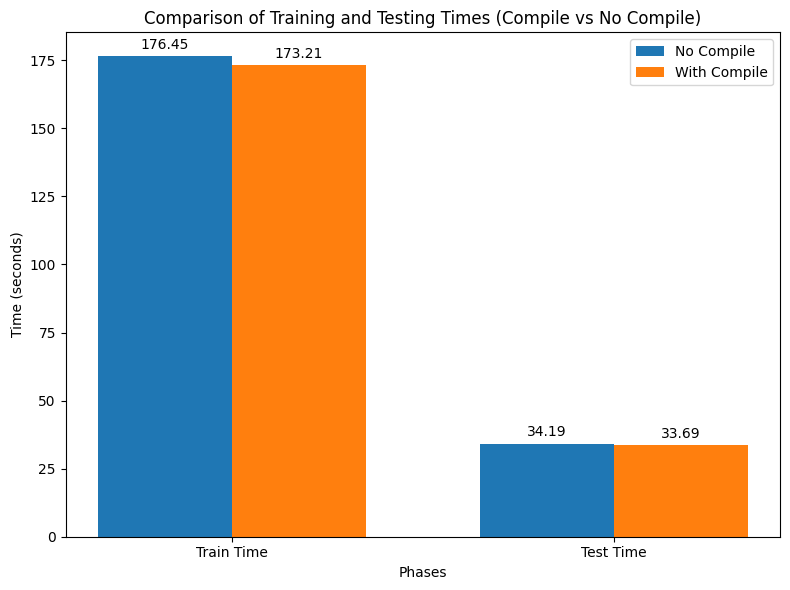

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data provided (mean values for training and testing times)
no_compile_train_time = no_compile_results_df.train_time.mean()
no_compile_test_time = no_compile_results_df.test_time.mean()
compile_train_time = compile_results_df.train_time.mean()
compile_test_time = compile_results_df.test_time.mean()

# Labels for the bars
labels = ['Train Time', 'Test Time']

# Values for the bars
no_compile_times = [no_compile_train_time, no_compile_test_time]
compile_times = [compile_train_time, compile_test_time]

# Set up positions for the bars
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

# Create the bar chart
fig, ax = plt.subplots(figsize=(8, 6))
rects1 = ax.bar(x - width/2, no_compile_times, width, label='No Compile')
rects2 = ax.bar(x + width/2, compile_times, width, label='With Compile')

# Add labels, title, and legend
ax.set_xlabel('Phases')
ax.set_ylabel('Time (seconds)')
ax.set_title('Comparison of Training and Testing Times (Compile vs No Compile)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Function to add labels on the bars
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

# Apply the label function to both sets of bars
add_labels(rects1)
add_labels(rects2)

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
## print out the mean values:
no_compile_train_time,no_compile_test_time,compile_train_time,compile_test_time

(176.4498579978943, 34.18645613193512, 173.21077938079833, 33.691231632232665)

### Discussion


In evaluating the model's training and testing performance, we analyzed the time required for both the compiled and non-compiled versions of the training and testing steps. The results are summarized as follows:

Non-compiled training time: 176.45 seconds
Non-compiled testing time: 34.19 seconds
Compiled training time: 173.21 seconds
Compiled testing time: 33.69 seconds

From these results, it is evident that the compiled version of the training and testing loops demonstrates slightly faster execution times compared to the non-compiled version. Specifically, the compiled training process shows a reduction of approximately 3.24 seconds (176.45 - 173.21), while the compiled testing process achieves a smaller improvement of about 0.5 seconds (34.19 - 33.69).

The performance gains, though modest, highlight the benefits of optimizing code execution through compilation. For larger datasets or more complex models, these time savings could scale significantly, making the compilation approach more advantageous in practical scenarios where efficiency is critical.



We observed that torch.compile introduces a longer training time in the first epoch due to the overhead of optimization. However, subsequent epochs benefit from these optimizations, resulting in reduced training times overall. This indicates that torch.compile is particularly advantageous for longer training runs, where the initial optimization overhead is amortized over time.

For shorter training runs, the non-compiled model edged out the compiled model in terms of training efficiency. The minimal optimization time spent behind the scenes did not provide significant benefits for shorter epochs, making the non-compiled model slightly faster on average.

### In summary:

torch.compile is highly beneficial for longer training runs, where it leverages optimization to reduce cumulative training time.
For shorter runs, the non-compiled model remains competitive due to lower overhead.

# Save the result:

In [ ]:
no_compile_results_df.to_csv("no_compile_result.csv")

In [ ]:
compile_results_df.to_csv("compile_result.csv")